# グラフの基礎
グラフは**頂点**(vertex)と**辺**(edge)から構成される．頂点は**接点*(ノード,node)，辺は**弧**(arc)，**リンク**(link)，**枝**(branch)などと呼ばれることもある．

ある二つの頂点が一つの辺でつながるとき，これらの頂点は隣接しているという．二つの辺についても同じ頂点を共有するときは隣接しているという．

ある頂点と隣接する頂点がいくつあるか，つまり何本の辺が出ているかは**次数**(degree)と呼ばれる．

## 隣接行列と隣接リスト
グラフを表現するための代表的なデータ構造には，隣接行列と隣接リストがある．

隣接行列は，行と列のサイズが等しい正方行列で，サイズはグラフに含まれる頂点の数になる．行列のi行j列の要素は，頂点iとjの間に辺があれば1,，それ以外は0となる．

無向グラフの隣接行列は対称行列となる．

隣接リストは，それぞれの頂点から見て，隣接する頂点を連結リストなどで保持するデータ構造．

ここでは隣接行列を使ってグラフに関するアルゴリズムを実装する．

pythonで使えるグラフのための外部パッケージに，NetworkXがある．

In [1]:
import networkx as nx
graph = nx.Graph()
graph.add_edge(5, 6)
graph.add_edge(6, 7)

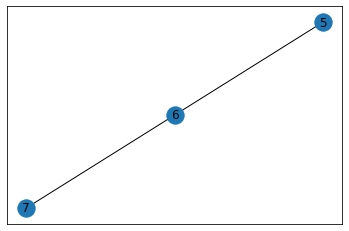

In [2]:
# Jupyter Notebookの場合
%matplotlib inline
nx.draw_networkx(graph) 

# グラフ探索のアルゴリズム
## グラフの生成

In [3]:
import random

def generate_graph(n, m):
    """ ｎ個の頂点とｍ個の辺をもつグラフを作る """
    graph_data = [[0] * n for i in range(n)]
    # 同じ辺が同一視されるようにsetを用意
    edge_set = set()
    while len(edge_set) < m:
        i, j = random.sample(range(n), 2)
        if i > j: i, j = j, i
        edge_set.add((i, j))
        graph_data[i][j] = graph_data[j][i] = 1
    return graph_data, edge_set

In [4]:
random.seed(6)
node_num = 16
edge_num = 20
my_graph, edge_set = generate_graph(node_num, edge_num)
edge_set

{(0, 2),
 (0, 4),
 (0, 8),
 (1, 9),
 (2, 5),
 (2, 7),
 (2, 13),
 (3, 12),
 (3, 15),
 (5, 11),
 (5, 13),
 (6, 8),
 (6, 11),
 (6, 13),
 (7, 8),
 (7, 11),
 (8, 10),
 (12, 13),
 (12, 15),
 (13, 14)}

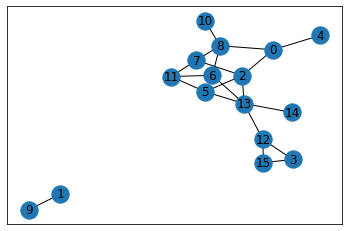

In [5]:
# NetworkXを使ってグラフを描画するコード
graph = nx.Graph()
for u,v in edge_set:
    graph.add_edge(u, v)
nx.draw_networkx(graph) 

In [6]:
my_graph

[[0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
 [1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1],
 [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0],
 [0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0],
 [1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0],
 [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1],
 [0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
 [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]]

## 連結グラフを探す
ある頂点から到達できる頂点を列挙することを考える．ある頂点の隣にある頂点は，隣接行列の一つの列あるいは行を見ればわかる．これはベクトルになるので，頂点iの隣接ベクトルも呼ばれる．

**幅優先探索**：近いところから順に到達できる頂点を探し尽くす．やれることから着々と足場を固めていくイメージ．

**深さ優先探索**：ひとまず行けるところまで行き，行きどまりになったら，最後に分岐した点まで戻り，探索を継続する．

まず幅優先探索の実装から行う．

### キュー
最初に並んだ人が，先にお会計をしてもらえるレジの仕組みと同じ．(**FIFO**)

キューは比較的簡単なデータ構造なので，Pythonのリストを使ってもすぐに実装できる．しかし，Pythonのリストでは，先頭の要素を取り除く処理に$O(n)$の時間がかかる．これを効率化できるdeque(デック)というクラスが，標準モジュールのcollectionsの中にある．

deque( : double-ended queue) は両側からデータの追加と取り出しが可能．appendで右側(末尾)からデータを追加し，左(先頭)からpopleftでデータを取り出す．

In [7]:
from collections import deque

queue = deque([])
queue.append(1)
queue.append(2)
queue.append(3)
print(queue)

deque([1, 2, 3])


In [8]:
print(queue.popleft())
print(queue)

1
deque([2, 3])


## グラフの幅優先探索
いまいる頂点の隣の頂点を列挙し，それを到達可能な点として保存していく．初めて見る頂点はキューに保存しておく．先に見つかったものが処理されるまで，後から見つかった頂点は処理されない．

In [9]:
def breadth_first_search(start, W):
    """ 隣接行列Wで表現されるグラフについて、
    startから到達できるnodeの一覧を返す
    """
    # リストをキューにする
    work_queue = deque([])
    visited = set()
    # 初期化
    work_queue.append(start)
    visited.add(start)
    while work_queue:
        print(work_queue)  # work_queueの中身を表示する
        # 今いる頂点
        here = work_queue.popleft()
        # 今いる頂点に隣接する頂点すべてを処理する
        for i, node in enumerate(W[here]):
            # 隣接しなければ何もしない
            if node == 0: continue
            if i not in visited:
                work_queue.append(i)
                visited.add(i)
    return visited

In [10]:
breadth_first_search(1, my_graph)

deque([1])
deque([9])


{1, 9}

In [11]:
breadth_first_search(10, my_graph)

deque([10])
deque([8])
deque([0, 6, 7])
deque([6, 7, 2, 4])
deque([7, 2, 4, 11, 13])
deque([2, 4, 11, 13])
deque([4, 11, 13, 5])
deque([11, 13, 5])
deque([13, 5])
deque([5, 12, 14])
deque([12, 14])
deque([14, 3, 15])
deque([3, 15])
deque([15])


{0, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15}

In [17]:
set_test = set()
set_test.add(3)
set_test.add(1)
set_test.add(2)
set_test  # setは自動的にソートされるぽい

{1, 2, 3}

### スタック
深さ優先探索は，調べるべき頂点をキューではなくスタックというデータ構造にに保存する．(**LIFO**)

Pythonのリストはappendメソッドで末尾にデータが付け加わり，popメソッドに引数を与えなければ末尾からデータが取り出される．→リストはそのままスタックとして活用できる．

## 深さ優先探索の実装

In [19]:
def depth_first_search(start, W):
    # リストをスタックとして利用する
    work_stack = []
    visited = set()
    work_stack.append(start)
    visited.add(start)
    while work_stack:
        print(work_stack)  # work_stackの中身を表示する
        here = work_stack.pop()
        for i, node in enumerate(W[here]):
            if node == 0: continue
            if i not in visited:
                work_stack.append(i)
                visited.add(i)
    return visited

In [22]:
depth_first_search(10, my_graph)

[10]
[8]
[0, 6, 7]
[0, 6, 2, 11]
[0, 6, 2, 5]
[0, 6, 2, 13]
[0, 6, 2, 12, 14]
[0, 6, 2, 12]
[0, 6, 2, 3, 15]
[0, 6, 2, 3]
[0, 6, 2]
[0, 6]
[0]
[4]


{0, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15}

## 最短距離を求めるアルゴリズム
いまスタート地点sから頂点ｖまでの最短距離をd(v)とする．vとuは隣接しており，スタート地点sから頂点uまでの最短距離を考える．sからuへの距離d(u)はいまはまだ最短距離かどうかわからない．ここで，d(u) > d(v) + 1であれば，d(u) = d(v) + 1とする．この操作を**緩和**という．

緩和はvまでの最短距離がわかっているという条件のもとで，sからuまでの最短距離を確定するという作業である．

グラフの最短距離を求めるアルゴリズムでは，まずすべての頂点にスタートの頂点からの仮の最短距離を割り当てる．そしてこの仮の最短距離を緩和によって順次本当の最短距離にいていけばよい．

どのような規則に従って緩和していくかが問題となる．

### ダイクストラ法
辺の重みが負でない場合に，ダイクストラ法によって最短距離を求められる．

ある頂点sから到達できる他のすべての頂点への最短距離を計算する．まず，sを除くすべての頂点への仮の最短距離を∞に初期化する．s自身への距離は0．

アルゴリズムがある頂点vに達した時点で，その頂点に割り当てられていrた仮の最短距離が，sからvへの正式な最短距離となる．

このアルゴリズムは，次に走査する頂点を，仮の最短距離で決める．この値が小さいものから優先して処理していく．

データ構造にはヒープ構造を用いる．ヒープは常に最小値が先頭に来るデータ構造なので，仮の最短距離を更新するたびに，これをヒープに入れておくだけで良い．次に走査する頂点をヒープから取り出すと，これが現時点でsに最も近い頂点となる・

In [29]:
import math
import heapq

def dijkstra(start, W):
    """ スタートの頂点と隣接行列を受け取り、
    到達できるすべての頂点への最短距離を返す。
    """
    # 仮の最短距離を∞に設定
    distance_list = [math.inf] * len(W)
    # スタートの頂点だけ距離を0にする
    distance_list[start] = 0
    # 最短距離が確定した頂点
    done_list = []
    # 次に処理する頂点を決めるためのヒープ
    wait_heap = []
    for i, d in enumerate(distance_list):
        # （スタートからの距離, 頂点）というタプルを作る
        heapq.heappush(wait_heap, (d, i))
    # ヒープが空っぽになるまで処理を続ける
    while wait_heap:
        p = heapq.heappop(wait_heap)
        i = p[1]
        if i in done_list:
            continue
        # この時点でスタートからiへの距離が確定する
        done_list.append(i)
        # i　に隣接するすべての頂点に対する処理
        for j, x in enumerate(W[i]):
            if x == 1 and j not in done_list:  # jがdone_listに入っていない，かつiと隣接する頂点ならば
                # 緩和
                d = min(distance_list[j], distance_list[i]+x)  # jまでの最短距離は,仮の最短距離あるいはiの最短距離+1
                distance_list[j] = d
                # ｊへの仮の最短距離をdとしてヒープに追加
                heapq.heappush(wait_heap, (d, j))  # まだjの最短距離が確定したわけではない
    return distance_list

10番から到達できない1番と9番は初期設定の∞のままとなっている．

In [30]:
dijkstra(10, my_graph)

[2, inf, 3, 5, 3, 4, 2, 2, 1, inf, 0, 3, 4, 3, 4, 5]

### ダイクストラ法の計算量
頂点数をn, 辺の数をmとする．このアルゴリズムでは，各頂点に到達したときにヒープからデータを1つ取り出す(1回のヒープの操作にかかる計算量：$O(\log n)$)．

また，各辺に対して緩和が行われるので，ヒープに新たなデータが追加される可能性がある．　→全体としての見積もりは$O((n+m)\log n)$.

辺と頂点の数が同じくらいなら，$O(n \log n)$，最も蜜なグラフを考えると$m=n^2$から$O(n^2 \log n)$となるので，$O((n+m)\log n)$はかなり幅のある見積もりである．

### すべての頂点間の最短距離
ダイクストラ法を用いてすべての頂点間の最短距離を求めようとすると，各頂点を出発点としてn回実行するという策がある．→$O(n(n+m)\log n)$ : グラフの密度が高ければ$O(n^3 \log n)$

## 動的計画法
**最適性の原理** : 全体が最適化されていると，ある一部分だけに着目してもその部分が最適化されている

最適性の原理を用いると，最適な全体は局所的に最適化された部分の集合でできていると考えられる．
動的計画法では，個別の最適解を次々にもとめていき，これをまとめ上げることで全体としての最適解を得る．

### Floyd-Warshall法
まずn^2個のすべての頂点ペアについて初期状態を設置する．ある頂点が隣接していたら，その辺は2点間の最短距離となる．隣接していなければ距離を無限大に設定する．

ここである1つの頂点xを考える．隣接していない頂点ペアuとvが，xを介してつながればそれは最短距離となる．$d^{k-1}(u,v)$をk-1番目までの頂点だけを考慮にいれているときにuとvの最短距離だとする．k番目の頂点を考慮したとき，．$d^k(u,v)$次の式で求められる．

$$d^k(u,v) = \min \{d^{k-1}(u,v), d^{k-1}(u,k) + d^{k-1}(k,v)\}$$

これはk番目の頂点が考慮すべき点に加わったときに，そこを通るべきかどうかを判定している．新たに加わったk番目の頂点を通ったほうが近いなら最短距離を更新する．

隣接行列と同じ形の行列を用意して，すべての頂点ペアをの最短距離を格納する．
まず，対角成分を0に，隣接行列で1になっている部分を1に，その他の部分を∞に初期化する．

In [31]:
def all_pairs_shortest_paths(W):
    # 頂点の数
    n = len(W)
    # 結果を格納する行列を用意する
    res = [[0] * n for i in range(n)]
    # 用意した行列を初期化する
    for i in range(n):
        for j in range(i, n):
            if i == j:
                val = 0
            elif W[i][j]:
                val = W[i][j]
            else:
                val = math.inf
            res[i][j] = res[j][i] = val
    # 動的計画法ですべての超点間の最短距離を求める
    for k in range(n):
        for u in range(n):
            for v in range(n):
                res[u][v] = min(res[u][v], res[u][k] + res[k][v])
    return res

In [32]:
all_pairs_shortest_paths(my_graph)

[[0, inf, 1, 4, 1, 2, 2, 2, 1, inf, 2, 3, 3, 2, 3, 4],
 [inf, 0, inf, inf, inf, inf, inf, inf, inf, 1, inf, inf, inf, inf, inf, inf],
 [1, inf, 0, 3, 2, 1, 2, 1, 2, inf, 3, 2, 2, 1, 2, 3],
 [4, inf, 3, 0, 5, 3, 3, 4, 4, inf, 5, 4, 1, 2, 3, 1],
 [1, inf, 2, 5, 0, 3, 3, 3, 2, inf, 3, 4, 4, 3, 4, 5],
 [2, inf, 1, 3, 3, 0, 2, 2, 3, inf, 4, 1, 2, 1, 2, 3],
 [2, inf, 2, 3, 3, 2, 0, 2, 1, inf, 2, 1, 2, 1, 2, 3],
 [2, inf, 1, 4, 3, 2, 2, 0, 1, inf, 2, 1, 3, 2, 3, 4],
 [1, inf, 2, 4, 2, 3, 1, 1, 0, inf, 1, 2, 3, 2, 3, 4],
 [inf, 1, inf, inf, inf, inf, inf, inf, inf, 0, inf, inf, inf, inf, inf, inf],
 [2, inf, 3, 5, 3, 4, 2, 2, 1, inf, 0, 3, 4, 3, 4, 5],
 [3, inf, 2, 4, 4, 1, 1, 1, 2, inf, 3, 0, 3, 2, 3, 4],
 [3, inf, 2, 1, 4, 2, 2, 3, 3, inf, 4, 3, 0, 1, 2, 1],
 [2, inf, 1, 2, 3, 1, 1, 2, 2, inf, 3, 2, 1, 0, 1, 2],
 [3, inf, 2, 3, 4, 2, 2, 3, 3, inf, 4, 3, 2, 1, 0, 3],
 [4, inf, 3, 1, 5, 3, 3, 4, 4, inf, 5, 4, 1, 2, 3, 0]]

# 練習問題

In [37]:
# 幅優先探索において，グラフの探索途中にできる木を出力する
def depth_first_search(start, W):
    # リストをスタックとして利用する
    work_stack = []
    visited = set()
    paths = []
    work_stack.append(start)
    visited.add(start)
    while work_stack:
        print(work_stack)  # work_stackの中身を表示する
        here = work_stack.pop()
        for i, node in enumerate(W[here]):
            if node == 0: continue
            if i not in visited:
                work_stack.append(i)
                visited.add(i)
                paths.append([here, i])
    return visited, paths

In [38]:
_, paths = depth_first_search(10, my_graph)
paths

[10]
[8]
[0, 6, 7]
[0, 6, 2, 11]
[0, 6, 2, 5]
[0, 6, 2, 13]
[0, 6, 2, 12, 14]
[0, 6, 2, 12]
[0, 6, 2, 3, 15]
[0, 6, 2, 3]
[0, 6, 2]
[0, 6]
[0]
[4]


[[10, 8],
 [8, 0],
 [8, 6],
 [8, 7],
 [7, 2],
 [7, 11],
 [11, 5],
 [5, 13],
 [13, 12],
 [13, 14],
 [12, 3],
 [12, 15],
 [0, 4]]

In [39]:
_, paths = depth_first_search(0, my_graph)
paths

[0]
[2, 4, 8]
[2, 4, 6, 7, 10]
[2, 4, 6, 7]
[2, 4, 6, 11]
[2, 4, 6, 5]
[2, 4, 6, 13]
[2, 4, 6, 12, 14]
[2, 4, 6, 12]
[2, 4, 6, 3, 15]
[2, 4, 6, 3]
[2, 4, 6]
[2, 4]
[2]


[[0, 2],
 [0, 4],
 [0, 8],
 [8, 6],
 [8, 7],
 [8, 10],
 [7, 11],
 [11, 5],
 [5, 13],
 [13, 12],
 [13, 14],
 [12, 3],
 [12, 15]]

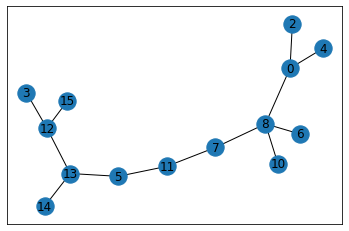

In [40]:
g = nx.Graph()
for u, v in paths:
    g.add_edge(u, v)
nx.draw_networkx(g)

In [41]:
fw_matrix = all_pairs_shortest_paths(my_graph)

In [42]:
fw_matrix

[[0, inf, 1, 4, 1, 2, 2, 2, 1, inf, 2, 3, 3, 2, 3, 4],
 [inf, 0, inf, inf, inf, inf, inf, inf, inf, 1, inf, inf, inf, inf, inf, inf],
 [1, inf, 0, 3, 2, 1, 2, 1, 2, inf, 3, 2, 2, 1, 2, 3],
 [4, inf, 3, 0, 5, 3, 3, 4, 4, inf, 5, 4, 1, 2, 3, 1],
 [1, inf, 2, 5, 0, 3, 3, 3, 2, inf, 3, 4, 4, 3, 4, 5],
 [2, inf, 1, 3, 3, 0, 2, 2, 3, inf, 4, 1, 2, 1, 2, 3],
 [2, inf, 2, 3, 3, 2, 0, 2, 1, inf, 2, 1, 2, 1, 2, 3],
 [2, inf, 1, 4, 3, 2, 2, 0, 1, inf, 2, 1, 3, 2, 3, 4],
 [1, inf, 2, 4, 2, 3, 1, 1, 0, inf, 1, 2, 3, 2, 3, 4],
 [inf, 1, inf, inf, inf, inf, inf, inf, inf, 0, inf, inf, inf, inf, inf, inf],
 [2, inf, 3, 5, 3, 4, 2, 2, 1, inf, 0, 3, 4, 3, 4, 5],
 [3, inf, 2, 4, 4, 1, 1, 1, 2, inf, 3, 0, 3, 2, 3, 4],
 [3, inf, 2, 1, 4, 2, 2, 3, 3, inf, 4, 3, 0, 1, 2, 1],
 [2, inf, 1, 2, 3, 1, 1, 2, 2, inf, 3, 2, 1, 0, 1, 2],
 [3, inf, 2, 3, 4, 2, 2, 3, 3, inf, 4, 3, 2, 1, 0, 3],
 [4, inf, 3, 1, 5, 3, 3, 4, 4, inf, 5, 4, 1, 2, 3, 0]]

In [43]:
def near_k(W, k):
    n = len(W)
    near_k_paths = []
    for i in range(n):
        for j in range(i+1, n):
            if W[i][j] <= k:
                near_k_paths.append([i, j])
    return near_k_paths

In [46]:
near_k(fw_matrix, 1)

[[0, 2],
 [0, 4],
 [0, 8],
 [1, 9],
 [2, 5],
 [2, 7],
 [2, 13],
 [3, 12],
 [3, 15],
 [5, 11],
 [5, 13],
 [6, 8],
 [6, 11],
 [6, 13],
 [7, 8],
 [7, 11],
 [8, 10],
 [12, 13],
 [12, 15],
 [13, 14]]

In [47]:
my_graph

[[0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
 [1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1],
 [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0],
 [0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0],
 [1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0],
 [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1],
 [0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
 [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]]

In [50]:
def degree(W): 
    """
    入力の隣接行列からそれぞれの頂点の次数を求める
    """
    n = len(W)
    degrees = []
    for i in range(n):
        degrees.append([i, W[i].count(1)])
    return degrees

In [49]:
degree(my_graph)

[[0, 3],
 [1, 1],
 [2, 4],
 [3, 2],
 [4, 1],
 [5, 3],
 [6, 3],
 [7, 3],
 [8, 4],
 [9, 1],
 [10, 1],
 [11, 3],
 [12, 3],
 [13, 5],
 [14, 1],
 [15, 2]]

# 練習問題解答

## 6.1

無向グラフとして表現できる事柄はたくさんある。本書でも例に挙げた、人間関係はわかりやすい例だ。経済活動に目を向けると、会社の取引関係もグラフ構造にできる。頂点が会社や個人事業主、辺は取引関係になる。商取引は、受発注で成り立っている。仕事を発注する側はお金を払い仕事を発注する。受注側はお金を受け取り、商品やサービスを提供する。これを向きを持った矢印で表現すれば、有向グラフになる。

インターネットは、世界中のコンピュータのネットワークなので、グラフ構造として表現できる。頂点はコンピュータ、辺は接続関係としよう。大型のコンピュータ同士は、LANケーブルで物理的に接続されていることが多い。家庭やオフィスで使われるPCやスマートフォンなどは無線通信で接続されていることが多いだろう。どちらにしても、これらのコンピュータが1つの巨大なグラフ構造になっているため、世界中のコンピュータへアクセスすることができる。通信は基本的には双方向なので、これは無向グラフと考えられるが、一般家庭への通信は上り（家庭からプロバイダー）と下り（プロバイダーから一般家庭）の通信速度が違うことが多いので、このことも考慮すると有向グラフとして表現できる。

人は気が付かないうちに、社会や周囲の人々から影響を受けているものだ。これを可視化するのは難しいかも知れないが、似たような事例をグラフで表現することはよくある。学術論文は、その論文を書くために参考にした文献を巻末にまとめる習慣がある。頂点を1つの論文、辺を引用関係にすればグラフができる。引用には向きがあるので、有向グラフとしても表現できる。

生活の中でグラフ構造として表現出来ることは無いか、いつも探し続けると楽しいかもしれない。

## 6.2

幅優先探索の例を示そう。変更した箇所にだけコメントを付けてある。

In [21]:
def breadth_first_search_with_path(start, W):
    work_queue = deque([])
    visited = set()
    # 頂点ペアを保持するリスト
    paths = []
    work_queue.append(start)
    visited.add(start)
    while work_queue:
        here = work_queue.popleft()
        for i, node in enumerate(W[here]):
            if node == 0: continue
            if i not in visited:
                work_queue.append(i)
                visited.add(i)
                # ここから、次の頂点
                paths.append([here, i])
    # 関数の戻り値にpathsを追加
    return visited, paths

In [22]:
# 1つ目の戻り値は使わないので、_としておく
_, paths = breadth_first_search_with_path(0, my_graph)
paths

[[0, 2],
 [0, 4],
 [0, 8],
 [2, 5],
 [2, 7],
 [2, 13],
 [8, 6],
 [8, 10],
 [5, 11],
 [13, 12],
 [13, 14],
 [12, 3],
 [12, 15]]

手作業でグラフを描いてもよいが、NetworkXを使うと便利だ。

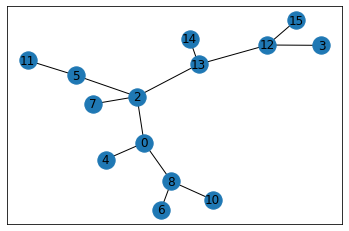

In [23]:
g = nx.Graph()
for u, v in paths:
    g.add_edge(u, v)
nx.draw_networkx(g)

頂点0から各頂点への経路がただ1つしか無いグラフ、つまり木構造になっているのがわかる。

## 6.3

まず、計算結果を変数に格納しよう。

In [24]:
fw_matrix = all_pairs_shortest_paths(my_graph)

In [25]:
fw_matrix

[[0, inf, 1, 4, 1, 2, 2, 2, 1, inf, 2, 3, 3, 2, 3, 4],
 [inf, 0, inf, inf, inf, inf, inf, inf, inf, 1, inf, inf, inf, inf, inf, inf],
 [1, inf, 0, 3, 2, 1, 2, 1, 2, inf, 3, 2, 2, 1, 2, 3],
 [4, inf, 3, 0, 5, 3, 3, 4, 4, inf, 5, 4, 1, 2, 3, 1],
 [1, inf, 2, 5, 0, 3, 3, 3, 2, inf, 3, 4, 4, 3, 4, 5],
 [2, inf, 1, 3, 3, 0, 2, 2, 3, inf, 4, 1, 2, 1, 2, 3],
 [2, inf, 2, 3, 3, 2, 0, 2, 1, inf, 2, 1, 2, 1, 2, 3],
 [2, inf, 1, 4, 3, 2, 2, 0, 1, inf, 2, 1, 3, 2, 3, 4],
 [1, inf, 2, 4, 2, 3, 1, 1, 0, inf, 1, 2, 3, 2, 3, 4],
 [inf, 1, inf, inf, inf, inf, inf, inf, inf, 0, inf, inf, inf, inf, inf, inf],
 [2, inf, 3, 5, 3, 4, 2, 2, 1, inf, 0, 3, 4, 3, 4, 5],
 [3, inf, 2, 4, 4, 1, 1, 1, 2, inf, 3, 0, 3, 2, 3, 4],
 [3, inf, 2, 1, 4, 2, 2, 3, 3, inf, 4, 3, 0, 1, 2, 1],
 [2, inf, 1, 2, 3, 1, 1, 2, 2, inf, 3, 2, 1, 0, 1, 2],
 [3, inf, 2, 3, 4, 2, 2, 3, 3, inf, 4, 3, 2, 1, 0, 3],
 [4, inf, 3, 1, 5, 3, 3, 4, 4, inf, 5, 4, 1, 2, 3, 0]]

この2次元配列を引数にとり、指定された距離以下の頂点ペアを出力する関数を作る。

In [26]:
def near_k(W, k):
    """ｋ以下の距離にある頂点ペアを返す。
    Wはグラフの頂点数と同じサイズの正方行列とする"""
    n = len(W)
    res = []
    for i in range(n):
        for j in range(i+1, n):
            if W[i][j] <= k: res.append((i, j))
    return res

In [27]:
near_k(fw_matrix, 1)

[(0, 2),
 (0, 4),
 (0, 8),
 (1, 9),
 (2, 5),
 (2, 7),
 (2, 13),
 (3, 12),
 (3, 15),
 (5, 11),
 (5, 13),
 (6, 8),
 (6, 11),
 (6, 13),
 (7, 8),
 (7, 11),
 (8, 10),
 (12, 13),
 (12, 15),
 (13, 14)]

いまは無向グラフを考えているため、行列は対称行列（対角成分を境に上下が同じ値）になっている。このため、ループで走査する領域は行列の上半分だけで十分になる。

## 6.4

隣接行列を引数に、各頂点の次数を計算する関数を作る。隣接行列が0と1から成っているので、それほど難しくない。

In [28]:
def degree(W):
    # キーが頂点、値が次数になる辞書を用意
    res = {}
    for i in range(len(W)):
        res[i] = sum(W[i])
    return res

In [29]:
degree(my_graph)

{0: 3,
 1: 1,
 2: 4,
 3: 2,
 4: 1,
 5: 3,
 6: 3,
 7: 3,
 8: 4,
 9: 1,
 10: 1,
 11: 3,
 12: 3,
 13: 5,
 14: 1,
 15: 2}

近年発達した複雑ネットワーク科学では、現実世界にみられるグラフ構造の多くで、極端に大きな次数をもつ頂点があることがわかっている。こうした頂点はハブ（hub）と呼ばれ、ネットワーク全体への影響力などがさまざまな観点から研究されている。